In [1]:
import bayes3d as b
import genjax
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import jax.tree_util as jtu
from tqdm import tqdm
import bayes3d.tabletop_model
from genjax._src.core.transforms.incremental import NoChange
from genjax._src.core.transforms.incremental import UnknownChange
from genjax._src.core.transforms.incremental import Diff
console = genjax.pretty(show_locals=False)

2023-06-26 16:52:31.927892: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7009/static/


In [3]:
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=500.0, fy=500.0,
    cx=50.0, cy=50.0,
    near=0.01, far=20.0
)

b.setup_renderer(intrinsics)
model_dir = os.path.join(b.utils.get_assets_dir(),"bop/ycbv/models")
meshes = []
for idx in range(1,22):
    mesh_path = os.path.join(model_dir,"obj_" + "{}".format(idx).rjust(6, '0') + ".ply")
    b.RENDERER.add_mesh_from_file(mesh_path, scaling_factor=1.0/1000.0)

b.RENDERER.add_mesh_from_file(os.path.join(b.utils.get_assets_dir(), "sample_objs/cube.obj"), scaling_factor=1.0/10000000000.0)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [4]:
contact_plane = b.t3d.inverse_pose(
    b.t3d.transform_from_pos_target_up(
        jnp.array([0.0, 2.0, 1.20]),
        jnp.array([0.0, 0.0, 0.0]),
        jnp.array([0.0, 0.0, 1.0]),
    )
)
root_poses = jnp.tile(contact_plane[None, ...],(4,1,1))
all_box_dims = b.RENDERER.model_box_dims

In [5]:
key = jax.random.PRNGKey(10)

In [7]:
VARIANCE_GRID = jnp.array([0.00001, 0.0001, 0.001])
OUTLIER_GRID = jnp.array([0.001, 0.0001])
OUTLIER_VOLUME = 100.0

grid_params = [
    (0.2, jnp.pi, (11,11,11)), (0.1, jnp.pi/3, (11,11,11)), (0.05, jnp.pi/5, (11,11,3)),
    (0.02, jnp.pi/5, (11,11,11)), (0.02, jnp.pi, (5,5,51))
]
contact_param_gridding_schedule = [
    b.make_translation_grid_enumeration_3d(
        -x, -x, -ang,
        x, x, ang,
        *nums
    )
    for (x,ang,nums) in grid_params
]

In [8]:
def c2f_contact_update(trace_, object_index, contact_param_deltas, VARIANCE_GRID, OUTLIER_GRID):
    contact_param_grid = contact_param_deltas + trace_["contact_params"][object_index]
    contact_param_full = jnp.tile(trace_["contact_params"][None,...], (contact_param_grid.shape[0],1,1))
    contact_param_full = contact_param_full.at[:,object_index].set(contact_param_grid)
    scores = b.tabletop_model.enumerator_score_vmap_jit(trace_, key, contact_param_full, VARIANCE_GRID, OUTLIER_GRID)
    i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)

    return contact_param_full[i], VARIANCE_GRID[j], OUTLIER_GRID[k]

c2f_contact_update_jit = jax.jit(c2f_contact_update)


In [9]:
likelihood = lambda o, r, variance, outlier_prob: b.threedp3_likelihood(
    o, r, variance, outlier_prob, 100.0, 3
)
likelihood_jit = jax.vmap(jax.vmap(jax.vmap(
    likelihood,
    in_axes=(None, None, None, 0)),
    in_axes=(None, None, 0, None)),
    in_axes=(None, 0, None, None)
)
contact_parallel = jax.vmap(
        b.scene_graph.poses_from_scene_graph,
        in_axes=(None, None, None, 0, None, None), out_axes=0
)

In [11]:
def c2f_contact_update_alternate(trace_, object_index, contact_param_deltas, VARIANCE_GRID, OUTLIER_GRID):
    contact_param_grid = contact_param_deltas + trace_["contact_params"][object_index]
    contact_param_full = jnp.tile(trace_["contact_params"][None,...], (contact_param_grid.shape[0],1,1))
    contact_param_full = contact_param_full.at[:,object_index].set(contact_param_grid)

    poses = contact_parallel(
        trace_.get_args()[1], trace_.get_args()[2], trace_["parents"], contact_param_full, trace_["face_parent"], trace_["face_child"])
    reconstruction = b.RENDERER.render_jax_parallel(
        poses , b.tabletop_model.get_indices(trace_)
    )

    scores = likelihood_jit(trace["image"], reconstruction, VARIANCE_GRID, OUTLIER_GRID)
    i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)
    return contact_param_full[i], VARIANCE_GRID[j], OUTLIER_GRID[k]

c2f_contact_update_alternate_jit = jax.jit(c2f_contact_update_alternate)

[21 20 20]


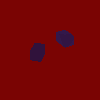

In [65]:
key, (_,gt_trace) = b.tabletop_model.importance_jit(key, genjax.choice_map({
    "parents": jnp.array([-1, 0, 0]), 
    "id_0": jnp.int32(21)
}), (jnp.arange(3), root_poses[:3], all_box_dims,))
b.tabletop_model.viz_trace_meshcat(gt_trace)
observed_image = gt_trace.get_retval()[0]
b.get_depth_image(observed_image[...,2])

In [66]:
key, (_,trace) = b.tabletop_model.importance_jit(key, genjax.choice_map({
    "parents": jnp.array([-1]), 
    "id_0": jnp.int32(21),
    "image": observed_image,
}), (jnp.arange(1), root_poses[:1], all_box_dims,))
b.tabletop_model.viz_trace_meshcat(trace)

[21]


In [68]:
%%time

all_paths = []
for obj_id in tqdm(range(len(b.RENDERER.meshes))):
    N = len(trace["parents"]) + 1
    object_index = N-1
    _, (_,trace_) = b.tabletop_model.importance_jit(key, genjax.choice_map(dict([
        ("parents", jnp.concatenate([trace["parents"], jnp.array([0])])),
        (f"id_{N-1}",jnp.int32(obj_id)),
        *[(f"id_{i}", trace[f"id_{i}"]) for i in range(N-1)],
        ("contact_params", jnp.concatenate([trace["contact_params"],jnp.zeros((1,3))])),
        ("image", observed_image),
        ("variance", VARIANCE_GRID[0]) ,
        ("outlier_prob", OUTLIER_GRID[0]) ,
    ])), (jnp.arange(N), root_poses[:N], all_box_dims,))

    object_number = trace["contact_params"].shape[0] - 1
    p = None
    trace_path = []
    trace_path.append(trace_)
    for c2f_iter in range(len(contact_param_gridding_schedule)):
        contact_param_deltas = contact_param_gridding_schedule[c2f_iter]
        contact, variance, outlier = c2f_contact_update_jit(trace_, object_index, contact_param_deltas, VARIANCE_GRID, OUTLIER_GRID)
        trace_ = b.tabletop_model.enumerator_trace_jit(trace_, key, contact, variance, outlier)
        # contact_param_deltas = contact_param_gridding_schedule[c2f_iter]
        # contact_param_grid = contact_param_deltas + trace_["contact_params"][object_index]
        # contact_param_full = jnp.tile(trace_["contact_params"][None,...], (contact_param_grid.shape[0],1,1))
        # contact_param_full = contact_param_full.at[:,object_index].set(contact_param_grid)
        # scores = enumerator_score_vmap_jit(trace_, contact_param_full, VARIANCE_GRID, OUTLIER_GRID)
        # i,j,k = jnp.unravel_index(scores.argmax(), scores.shape)
        # print(i,j,k)
        # trace_ = enumerator_trace_jit(trace_, contact_param_full[i], VARIANCE_GRID[j], OUTLIER_GRID[k])
        trace_path.append(trace_)
    all_paths.append(
        trace_path
    )

scores = jnp.array([t[-1].get_score() for t in all_paths])
print(scores)
normalized_scores = b.utils.normalize_log_scores(scores)

trace = all_paths[jnp.argmax(scores)][-1]
b.tabletop_model.viz_trace_meshcat(trace)

print(b.tabletop_model.get_indices(trace))
print(b.tabletop_model.get_indices(gt_trace))

100%|██████████████████████████████████████████████████████████████████████| 22/22 [00:10<00:00,  2.03it/s]

[126440.97 121305.66 139597.17 146239.6  140072.97 149179.94 150056.42
 149278.47 147658.56 150376.9  110467.66 128756.2  131875.53 145707.62
 139967.   116722.53 147859.81 149635.28 147601.86 143652.56 156131.5
 147206.56]
[21 20 20]
CPU times: user 8.03 s, sys: 3 s, total: 11 s
Wall time: 11 s
